In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.fluidsim2d import FluidSim2DModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
import seaborn as sns
%matplotlib inline
sns.set_style('white')
rc('animation', html='html5')

## Model


In [2]:
n_steps = 500
seed = 20171027
rng = np.random.RandomState(seed)
grid_shape = (128, 128)
init_velocity_mean = np.zeros((2,) + grid_shape)
u0, u1 = np.meshgrid(
    np.linspace(-5, 5, grid_shape[0]), 
    np.linspace(-5, 5, grid_shape[1]), indexing='ij')
init_density_mean = np.zeros(grid_shape)
init_density_mean[(u0**2 + u1**2 < 1.)] = 10.
init_state_mean = np.concatenate([
    init_velocity_mean.flatten(),
    init_density_mean.flatten()
])
init_state_std = np.concatenate([
    np.ones(2 * grid_shape[0] * grid_shape[1]) * 0.5,
    np.ones(grid_shape[0] * grid_shape[1]) * 0.1
]) 
state_noise_std = 0.001
obser_noise_std = 0.1
dt = 0.05
model = FluidSim2DModel(
    rng=rng, grid_shape=grid_shape,
    init_state_mean = init_state_mean, init_state_std=init_state_std, 
    state_noise_std=state_noise_std, obser_noise_std=obser_noise_std, dt=dt, use_vort_conf=False)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
dens = z_reference[0, -grid_shape[0] * grid_shape[1]:].reshape(grid_shape)
im = ax.imshow(dens.T, cmap='inferno', vmax=5)

def init():
    dens = z_reference[0, -grid_shape[0] * grid_shape[1]:].reshape(grid_shape)
    im.set_data(dens)
    return (im,)

def animate(i):
    dens = z_reference[i, -grid_shape[0] * grid_shape[1]:].reshape(grid_shape)
    im.set_data(dens)
    return (im,)

plt.close(fig)

anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=n_steps, 
    interval=20, blit=True)

HTML(anim.to_html5_video())

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
vel = z_reference[-1, :-grid_shape[0] * grid_shape[1]].reshape((2,) + grid_shape)
skip = 4
qu = ax.quiver(vel[0, ::skip, ::skip], vel[1, ::skip, ::skip])

def init():
    vel = z_reference[0, :-grid_shape[0] * grid_shape[1]].reshape((2,) + grid_shape)
    qu.set_UVC(vel[0, ::skip, ::skip], vel[1, ::skip, ::skip])
    return (qu,)

def animate(i):
    vel = z_reference[i, :-grid_shape[0] * grid_shape[1]].reshape((2,) + grid_shape)
    qu.set_UVC(vel[0, ::skip, ::skip], vel[1, ::skip, ::skip])
    return (qu,)

plt.close(fig)

anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=n_steps, 
    interval=20, blit=True)

HTML(anim.to_html5_video())

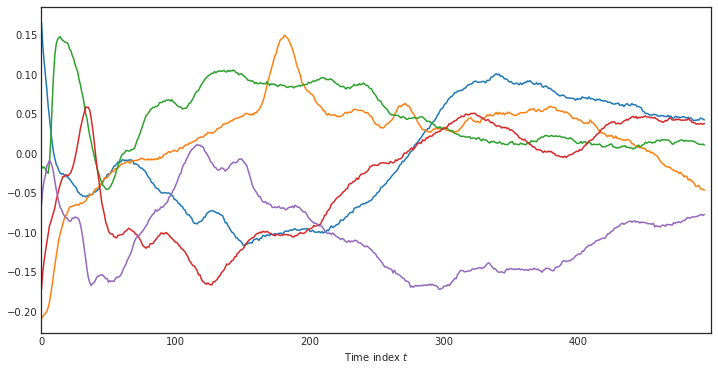

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference[5:, :1000:200])
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)

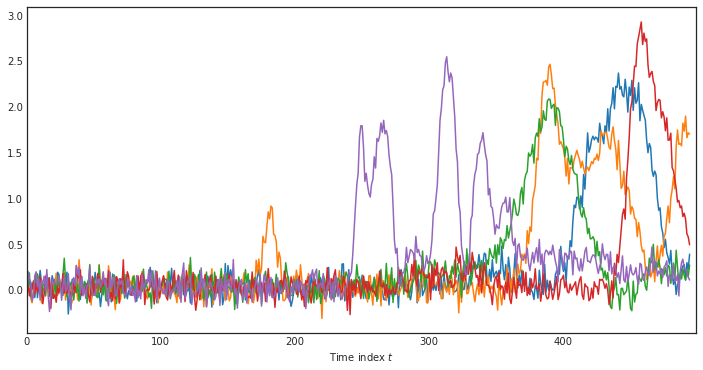

In [7]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference[5:, :1000:200])
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)

## Infer state from observations

### Ensemble Kalman filter (perturbed observations)

In [8]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [9]:
%%time
results_enkf = enkf.filter(x_reference, 8)

CPU times: user 1min 56s, sys: 6.16 s, total: 2min 2s
Wall time: 1min 2s


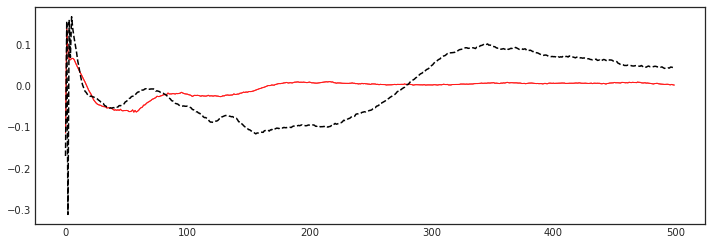

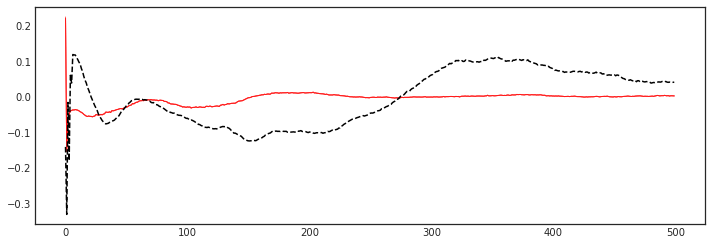

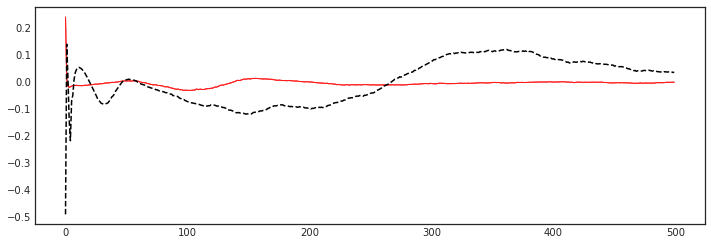

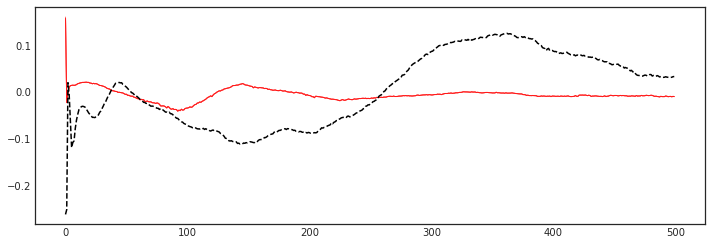

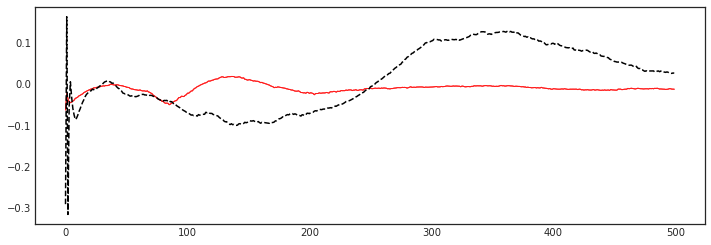

In [10]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_enkf['z_particles_seq'][:, :, i], 'r-', lw=1, alpha=0.25, label='EnkF')
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Bootstrap particle filter

In [11]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [12]:
%%time
results_bspf = bspf.filter(x_reference, 8)

CPU times: user 50.2 s, sys: 4.6 s, total: 54.8 s
Wall time: 54.9 s


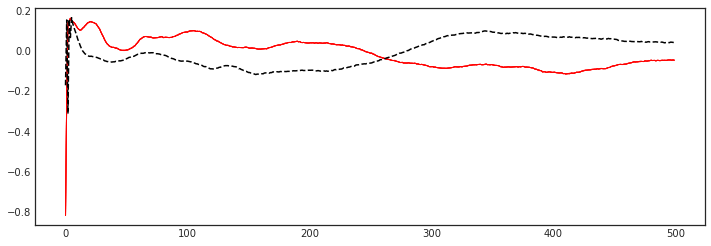

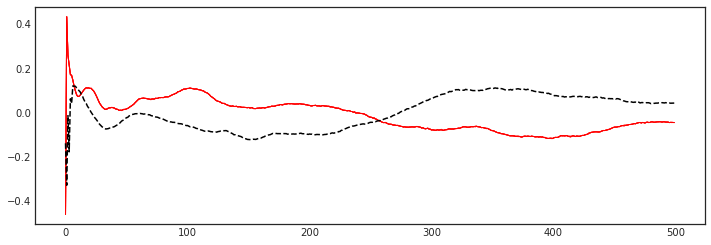

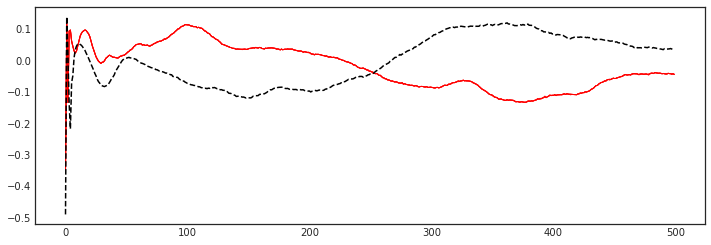

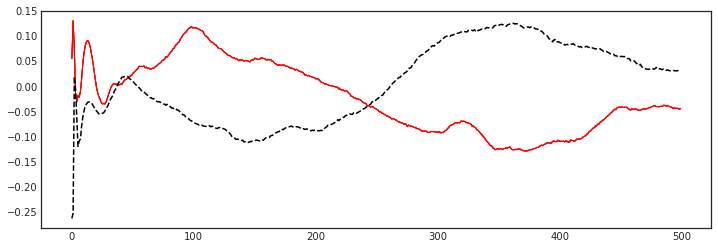

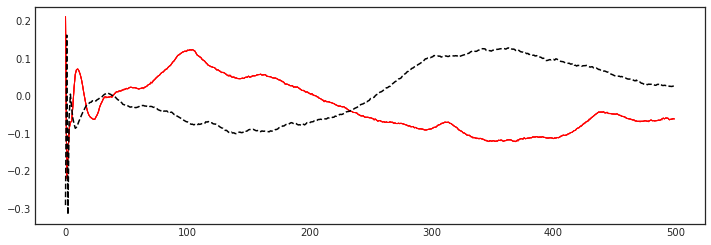

In [13]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_bspf['z_particles_seq'][:, :, i], 'r-', lw=1., alpha=0.5, label='EnkF')
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Ensemble transform particle filter

In [ ]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [ ]:
%%time
results_etpf = etpf.filter(x_reference, 8)

In [ ]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    _ = ax.plot(results_etpf['z_particles_seq'][:, :, i], 'r-', lw=1, alpha=0.5, label='EnkF')
    _ = ax.plot(z_reference[:, i], 'k--', label='True')

### Visualise estimated means of filtering distribution

In [ ]:
plt.close('all')
for i in range(5):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(z_reference[:, i], 'k', label='True')
    ax.plot(results_enkf['z_mean_seq'][:, i], ':', label='EnKF')
    ax.plot(results_bspf['z_mean_seq'][:, i], '--', label='BSPF')
    #ax.plot(results_etpf['z_mean_seq'][:, i], '-.', label='ETPF')
    ax.legend(ncol=4)